# Лабораторная работа №2

## Экстремальные задачи нелинейного программирования

Найти хотя бы один минимум целевой функции $J(u)$ для конечномерных управлений $u ∈ E^2$ с точностью $\epsilon = 10^{-13}$ градиентным методом наискорейшего спуска и методом Ньютона. Нарисуйте приблизительные линии уровня вашей функции и полученные траектории спуска (первые три шага) к минимуму. 

### Импорт необходимых библиотек

In [1]:
import numpy as np
import sympy as sp

import matplotlib.pyplot as plt

In [2]:
from core.gradient_methods import *
from core.newton_method import *
from core.visualization import *

### Построение графика функции

Функция по варианту имеет вид:

\begin{equation}
J(u) = u_1^2 + 10(u_2 - 1)^2
\end{equation}

Определим ее

In [3]:
def J(u1, u2):
    return u1**2 + 10 * (u2 - 1) ** 2 

Определим интервал, на котором будет построен график функции и количество используемых точек (влияет на гладкость)

In [4]:
U1_LOWER_BOUND = -20
U1_UPPER_BOUND = 50
U2_LOWER_BOUND = -50
U2_UPPER_BOUND = 50
COUNT = 100

Точность вычисления

In [5]:
EPSILON = 1e-13

Инициализируем значения функции на выбранном интервале и построим ее график

In [6]:
u1_range = np.linspace(U1_LOWER_BOUND, U1_UPPER_BOUND, COUNT)
u2_range = np.linspace(U2_LOWER_BOUND, U2_UPPER_BOUND, COUNT)

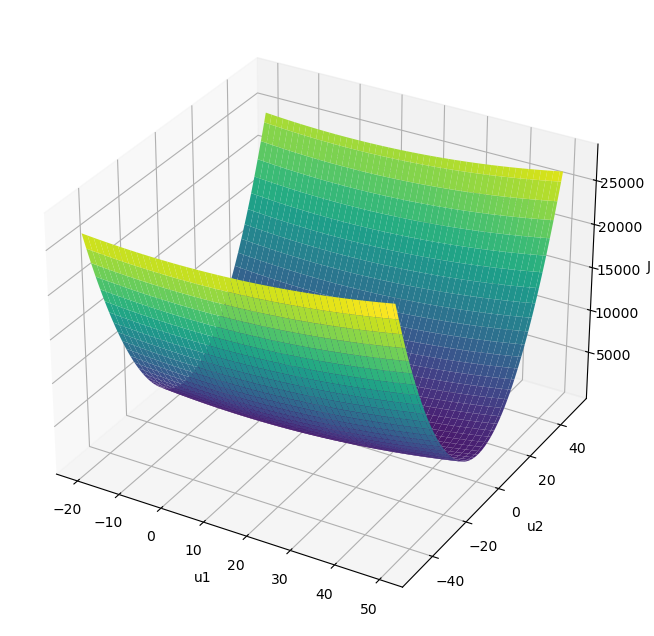

In [7]:
plot_3d_graph(u1=u1_range, u2=u2_range, j_function=J, x_label='u1', y_label='u2', z_label='J')

Построим также линии уровня функции

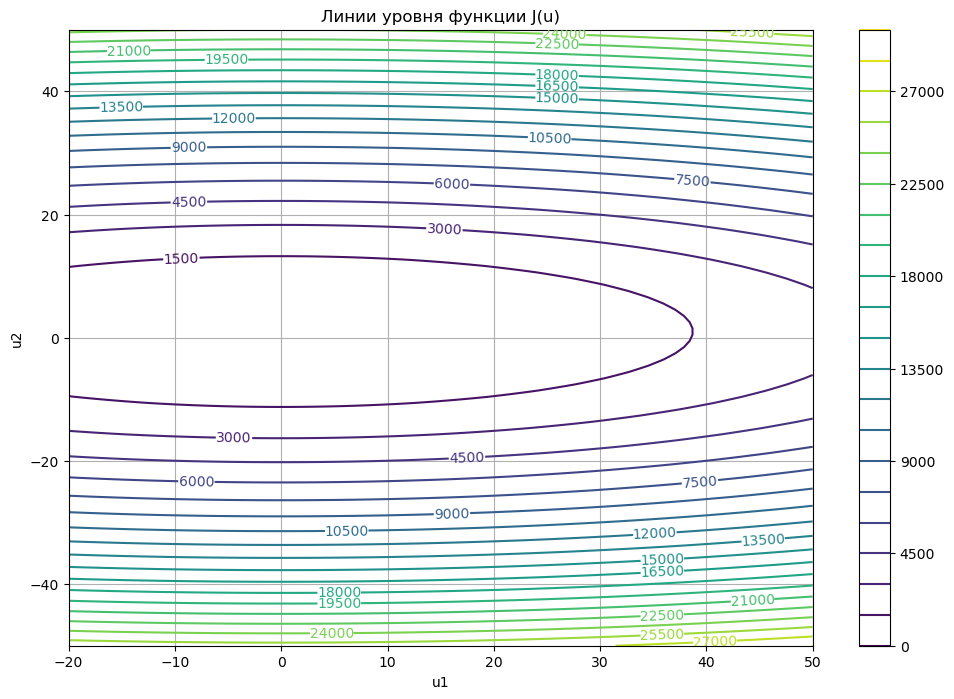

In [8]:
plot_function_levels(u1=u1_range, u2=u2_range, j_function=J, levels=20, x_label='u1', y_label='u2', 
                     title='Линии уровня функции J(u)')

Посмотрев на функцию аналитически, легко заметить, что ее минимум будет достигаться в точке (0; 1), в которой значение функции будет равным `0`

Посмотрим, как хорошо приблизятся к этому значению `градиентный метод наискорейшего спуска` и `метод Ньютона`

### Инициализация производных функции

Для реализации рассматриваемых в работе методов, нам необходимо знать первые производные исходной функции, что будет использовано при вычислении ее градиента, поэтому определим эти производные

Проинициализируем исходную функцию в символьном виде

In [9]:
u1, u2 = sp.symbols('u1 u2')

In [10]:
j = u1**2 + 10 * (u2 - 1) ** 2

Определим производную по $u_1$

In [11]:
dj_u1 = sp.diff(j, u1)
dj_u1

2*u1

Определим производную по $u_2$

In [12]:
dj_u2 = sp.diff(j, u2)
dj_u2

20*u2 - 20

Приведем производные в более удобный для дальнейших вычислений формат

In [13]:
dj_u1_func = sp.lambdify((u1, u2), dj_u1)
dj_u2_func = sp.lambdify((u1, u2), dj_u2)

### Поиск экстремума градиентным методом наискорейшего спуска

Суть градиентного метода наискорейшего спуска заключается в следующем:

пусть у нас есть начальное приближение $u^k$, представляющее собой список компонент функции, тогда мы можем вычислить следующее приближение $u^{k+1}$ по формуле:

\begin{equation}
u^{k+1} = u^k - b^k \nabla J(u^k)
\end{equation} 

где $\nabla J(u^k)$ - градиент функции $J(u)$ в точке (многокомпонентной) $u^k$

Фактически, градиент функции показывает направление максимального роста функции, а поскольку мы минимизируем ее, то новое приближение будем получать с помощью знака "минус", то есть двигаться в направлении `антиградиента`

Значение $b^k$ определяет скорость спуска и может быть как постоянным, эвристически меняющимся по итерациям и гарантирующим наискорейший спуск.

В данном случае будем использовать последний подход

Для поиска оптимального $b^k$ на каждом шаге необходимо минимизировать функцию:

\begin{equation}
J(b) = J(u^k - b \nabla J(u^k))
\end{equation}

методом дихотомии или золотого сечения, то есть произвести одномерную оптимизацию на отрезке $[u_a, u_b]$, где $u_a$ и $u_b$ - многокомпонентные точки

В качестве $u_a$ зададим текущее приближение $u^k$, а $u_b$ вычислим по формуле:

\begin{equation}
u_b = u^k - \frac{\Delta u}{||\nabla J(u^k)||} \nabla J(u^k)
\end{equation}

где $\Delta u$ - относительно большой шаг, одинаковый для всех итераций, гарантирующий $J(u_b)\ge J(u_a)$, то есть наличие минимума в искомом отрезке

В результате оптимизации $J(u)$ на отрезке $[u_a, u_b]$ мы получим точку-минимум, именно она будет <ins>**СЛЕДУЮЩИМ ПРИБЛИЖЕНИЕМ**</ins>, то есть фактически мы не вычисляем $b^k$, а ищем новое приближение, соответствующее оптимальному $b^k$

В качестве условия остановки для всех алгоритмов будем использовать:

\begin{equation}
\Delta u^k = ||u^k - u^{k+1}|| \le \epsilon
\end{equation}

Оно демонстрирует тот факт, что разница между текущим и следующим приближениями ничтожно мала, а значит работу алгоритма необходимо завершить

Зададим начальное приближение

In [14]:
u1_start = 37
u2_start = 44

Выполним сам поиск экстремума

In [15]:
trajectory, steps, internal_steps = fast_gradient_descent(u1_start=u1_start, u2_start=u2_start, j_function=J, dj_u1=dj_u1_func, 
                                                          dj_u2=dj_u2_func, epsilon=EPSILON, step=100)

Посмотрим на результат

In [16]:
print(f"Минимум функции был найден за общее число итераций: {steps + internal_steps}")
print(f"Из них внешних итераций: {steps}")
print(f"Внутренних: {internal_steps}")

Минимум функции был найден за общее число итераций: 508
Из них внешних итераций: 24
Внутренних: 484


Как видно, метод сошелся за 24 внешние итерации, что говорит о том, что приближения находились довольно качественно, однако большинство "затрат" (484 итерации) пришлось на поиск этих самых приближений, на что мог повлиять достаточно специфичный шаг, определяющий интервал поиска нового приближения. 

В качестве метода поиска нового приближения использовался метод `золотого сечения`

Посмотрим на найденную точку-экстремум

In [17]:
extremum_by_gradient_descent = trajectory[-1]
extremum_by_gradient_descent

array([5.96822307e-14, 1.00000000e+00, 4.27391562e-27])

In [18]:
print(
    f"Найденный минимум (с точностью {EPSILON}) находится в точке "
    f"({extremum_by_gradient_descent[0]}, {extremum_by_gradient_descent[1]}), "
    f"значение функции в ней составляет {extremum_by_gradient_descent[2]}"
)

Найденный минимум (с точностью 1e-13) находится в точке (5.96822306651828e-14, 1.0000000000000084), значение функции в ней составляет 4.273915624134049e-27


Как видно, точка находится очень близко к верному аналитическому значению и удовлетворяет условию задачи при заданной точности $\epsilon$

Построим историю поиска экстремума на 3-х мерном графике и на линиях уровня

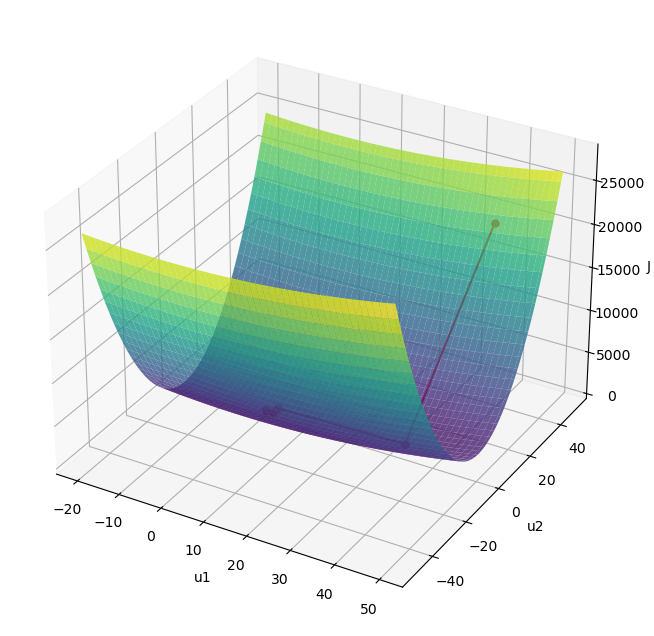

In [19]:
plot_3d_graph(u1=u1_range, u2=u2_range, j_function=J, x_label='u1', y_label='u2', z_label='J', trajectory=trajectory)

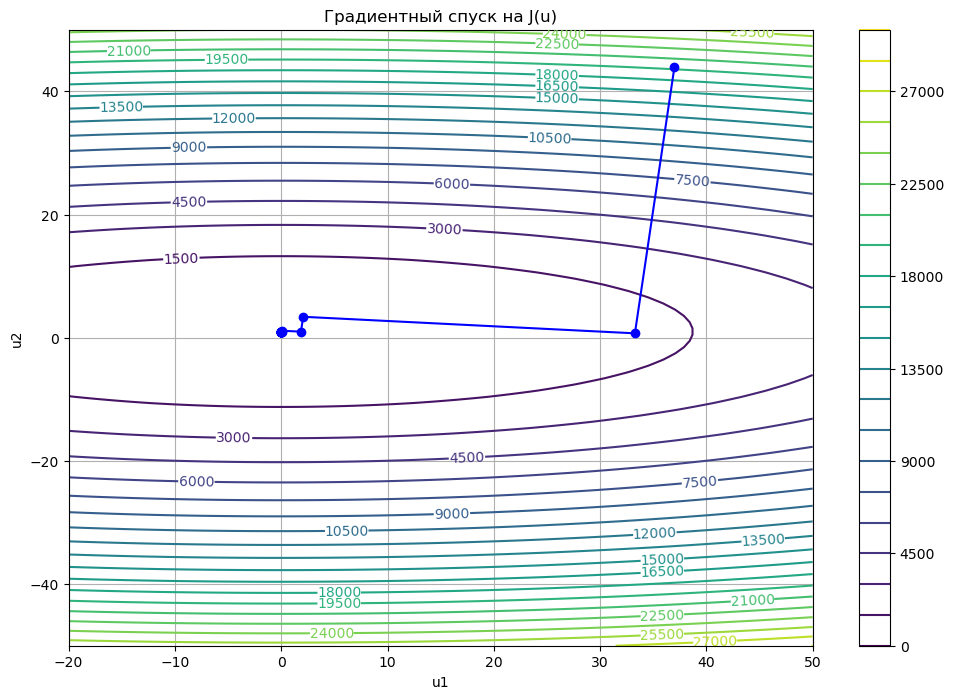

In [20]:
plot_function_levels(u1=u1_range, u2=u2_range, j_function=J, levels=20, x_label='u1', y_label='u2', 
                     title='Градиентный спуск на J(u)', trajectory=trajectory)

Как видно из графиков, за первые 3 итерации алгоритм близко подошел к искомой точке, далее наблюдалась слабозаметная калибровка около исходной точки с целью удовлетворения условию остановки

### Поиск экстремума методом Ньютона

Суть метода Ньютона заключается в следующем:

пусть у нас есть начальное приближение $u^k$, аналогичное начальному приближению для метода градиентного наискорейшего спуска, тогда мы можем вычислить следующее приближение $u^{k+1}$ по формуле:

\begin{equation}
u^{k+1} = u^k + p(u^k)
\end{equation}

где 

\begin{equation}
p(u^k) = - H^{-1}(u^k)\nabla J(u^k)
\end{equation}

$p(u^k)$ можно найти, решив линейную систему уравнений $Hp = - \nabla J$ в каждой точке $u^k$ методом Гаусса. В данном случае мы будем использовать градиент и обратный Гессиан функции напрямую

Поскольку метод аппроксимирует целевую функцию как параболу, то, если она является параболоидом, ожидается что метод Ньютона найдет экстремум этой функции за 1 итерацию. В нашем случае мы как раз работаем с такой функцией, поэтому также проверим этот факт

Вычислим Гессиан целевой функции в символьном виде

In [21]:
hessian = sp.hessian(j, (u1, u2))
hessian

Matrix([
[2,  0],
[0, 20]])

Как видно, Гессиан состоит из одних констант, поскольку максимальная степень компонент в целевой функции 2, что совпадает с их количеством

Выполним сам поиск экстремума

In [22]:
newton_trajectory, iterations = newton_method(u1_start=u1_start, u2_start=u2_start, j_function=J, dj_u1=dj_u1_func, 
                                              dj_u2=dj_u2_func, hessian=hessian, epsilon=EPSILON)

Посмотрим на результат

In [23]:
print(f"Минимум функции был найден за число итераций: {iterations}")

Минимум функции был найден за число итераций: 1


Экстремум был найден за 1 итерацию, что подтверждает предыдущее наблюдение

Посмотрим на найденную точку-экстремум

In [24]:
extremum_by_newton_method = newton_trajectory[-1]
extremum_by_newton_method

array([0., 1., 0.])

In [25]:
print(
    f"Найденный минимум (с точностью {EPSILON}) находится в точке "
    f"({extremum_by_newton_method[0]}, {extremum_by_newton_method[1]}), "
    f"значение функции в ней составляет {extremum_by_newton_method[2]}"
)

Найденный минимум (с точностью 1e-13) находится в точке (0.0, 1.0), значение функции в ней составляет 0.0


Как видно, найденная точка **полностью** совпала с аналитическим минимумом функции, что говорит о *максимальной* эффективности метода Ньютона в контексте целевой функции, поскольку экстремум был найден **точно** и за 1 итерацию

Построим историю поиска экстремума на 3-х мерном графике и на линиях уровня

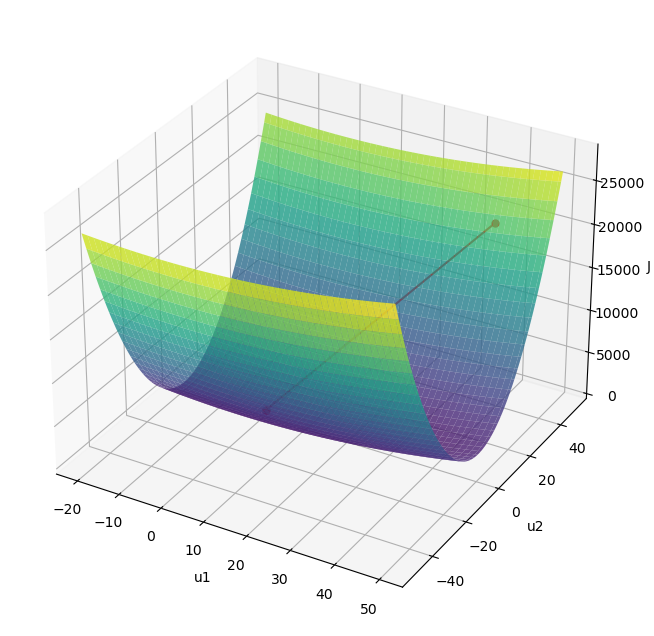

In [26]:
plot_3d_graph(u1=u1_range, u2=u2_range, j_function=J, x_label='u1', y_label='u2', z_label='J', trajectory=newton_trajectory)

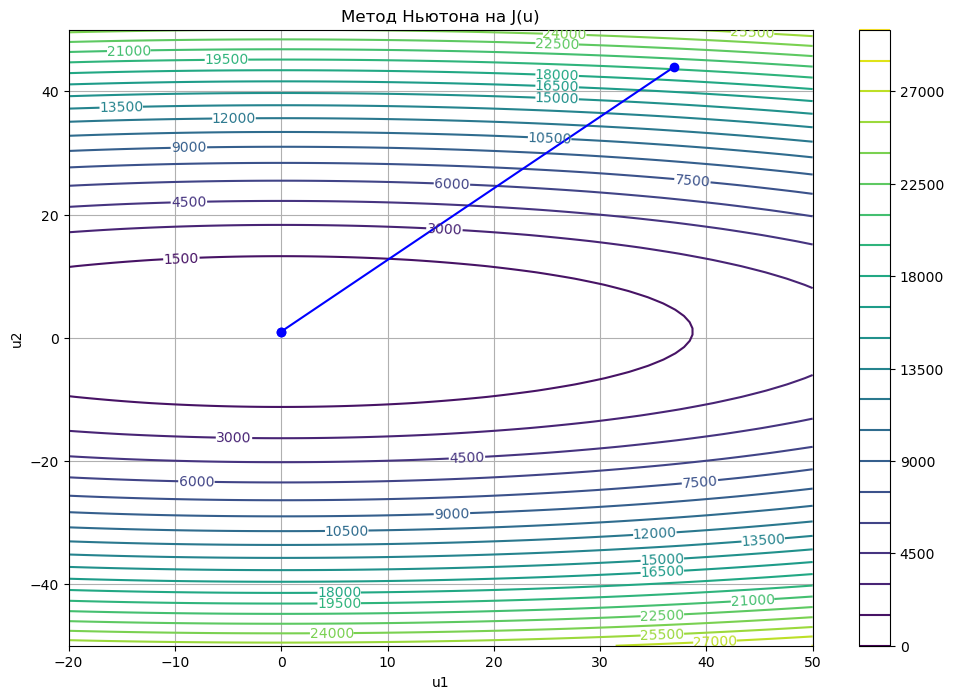

In [27]:
plot_function_levels(u1=u1_range, u2=u2_range, j_function=J, levels=20, x_label='u1', y_label='u2', 
                     title='Метод Ньютона на J(u)', trajectory=newton_trajectory)

Как видно из графиков, метод Ньютона сразу попал в искомую точку-экстремум